# Preprocessing the coordinate data

In [72]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from shapely.geometry import Point
from tqdm import tqdm

In [73]:
# Main
def add_lsoa_codes_by_coordinates(
    file_path,
    longitude_col,
    latitude_col,
    gm_lsoa_shapefile,  # Path to Greater Manchester LSOA shapefile
    output_dir="data/preprocessed",
    crs="EPSG:4326",    # WGS84 coordinate system
    lsoa_code_field=None  # Name of LSOA code field in the shapefile (will auto-detect if None)
):
    """
    Process a dataset with longitude and latitude coordinates and add LSOA codes.

    Parameters:
    file_path (str): Path to the dataset file (CSV, Excel, etc.)
    longitude_col (str): Name of the column containing longitude values
    latitude_col (str): Name of the column containing latitude values
    output_dir (str): Directory to save output files and visualizations
    crs (str): Coordinate reference system of input coordinates
    batch_size (int): Number of coordinates to process in one API batch
    use_api (bool): Whether to use ONS API (True) or local shapefile (False)
    gm_lsoa_shapefile (str): Path to Greater Manchester LSOA shapefile if use_api=False

    Returns:
    pd.DataFrame: Dataset with added LSOA codes
    dict: Paths to generated outputs for reporting
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Extract filename without extension for reporting
    base_filename = os.path.basename(file_path).split('.')[0]

    print(f"Processing dataset: {file_path}")

    # Determine file type and load accordingly
    # Determine file type and load accordingly
    if file_path.endswith('.csv'):
        try:
            df = pd.read_csv(file_path, low_memory=False)
        except UnicodeDecodeError:
            # Try with different encodings
            for encoding in ['latin1', 'cp1252', 'iso-8859-1']:
                try:
                    df = pd.read_csv(file_path, low_memory=False, encoding=encoding)
                    print(f"Successfully read file with {encoding} encoding")
                    break
                except UnicodeDecodeError:
                    continue
            else:
                raise ValueError("Could not read file with any of the attempted encodings")
    elif file_path.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV or Excel.")

    print(f"Original dataset shape: {df.shape}")

    # Save a summary of the original dataset
    with open(f"{output_dir}/{base_filename}_{timestamp}_summary.txt", "w") as f:
        f.write(f"Dataset Analysis: {file_path}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Original dataset shape: {df.shape}\n\n")
        f.write("Column Names:\n")
        for col in df.columns:
            f.write(f"- {col}\n")
        f.write("\n")

    # Basic data cleaning
    # 1. Remove duplicate rows
    df_clean = df.drop_duplicates()
    duplicates_removed = len(df) - len(df_clean)
    print(f"Removed {duplicates_removed} duplicate rows. New shape: {df_clean.shape}")

    # 2. Standardize column names
    df_clean.columns = [col.lower().replace(' ', '_') for col in df_clean.columns]
    longitude_col = longitude_col.lower().replace(' ', '_')
    latitude_col = latitude_col.lower().replace(' ', '_')

    # 3. Check for longitude and latitude columns
    if longitude_col not in df_clean.columns or latitude_col not in df_clean.columns:
        raise ValueError(f"Coordinate columns not found. Looking for '{longitude_col}' and '{latitude_col}'. Available columns: {df_clean.columns.tolist()}")

    # 4. Clean coordinate data
    # Convert to numeric and handle non-numeric values
    df_clean[longitude_col] = pd.to_numeric(df_clean[longitude_col], errors='coerce')
    df_clean[latitude_col] = pd.to_numeric(df_clean[latitude_col], errors='coerce')

    # Count missing coordinates
    missing_coords = df_clean[df_clean[longitude_col].isna() | df_clean[latitude_col].isna()]
    print(f"Records with missing coordinates: {len(missing_coords)} ({len(missing_coords)/len(df_clean):.2%})")

    # Basic coordinate validation (for UK coordinates)
    # UK longitude range approximately -8 to 2
    # UK latitude range approximately 50 to 61
    invalid_coords = df_clean[
        ((df_clean[longitude_col] < -8) | (df_clean[longitude_col] > 2) |
        (df_clean[latitude_col] < 50) | (df_clean[latitude_col] > 61)) &
        (~df_clean[longitude_col].isna() & ~df_clean[latitude_col].isna())
    ]

    print(f"Records with invalid UK coordinates: {len(invalid_coords)} ({len(invalid_coords)/len(df_clean):.2%})")

    # 5. Create a geometry column for spatial operations
    # Create a copy with only valid coordinates for geocoding
    df_valid = df_clean.dropna(subset=[longitude_col, latitude_col]).copy()
    df_valid = df_valid[
        (df_valid[longitude_col] >= -8) & (df_valid[longitude_col] <= 2) &
        (df_valid[latitude_col] >= 50) & (df_valid[latitude_col] <= 61)
    ]

    print(f"Valid coordinates for geocoding: {len(df_valid)} ({len(df_valid)/len(df_clean):.2%})")

    # Create geometry column for valid coordinates
    df_valid['geometry'] = df_valid.apply(
        lambda row: Point(row[longitude_col], row[latitude_col]),
        axis=1
    )

    # 6. Determine LSOA for each coordinate using shapefile
    # Check if shapefile exists
    if not os.path.exists(gm_lsoa_shapefile):
        raise ValueError(f"Greater Manchester LSOA shapefile not found at: {gm_lsoa_shapefile}")

    print(f"Using shapefile for geocoding: {gm_lsoa_shapefile}")

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df_valid, geometry='geometry', crs=crs)

    # Load Greater Manchester LSOA shapefile
    print("Loading LSOA shapefile...")
    try:
        # First check if the shapefile exists
        if not os.path.exists(gm_lsoa_shapefile):
            raise FileNotFoundError(f"Shapefile not found at {gm_lsoa_shapefile}")

        gm_lsoa = gpd.read_file(gm_lsoa_shapefile)
        print(f"Loaded shapefile successfully with {len(gm_lsoa)} polygons")
    except Exception as e:
        print(f"Error loading shapefile: {str(e)}")

        # Fall back to PyShp if available
        try:
            import shapefile
            from shapely.geometry import shape

            print("Attempting to use PyShp as fallback...")
            sf = shapefile.Reader(gm_lsoa_shapefile)

            # Extract fields and records
            fields = [field[0] for field in sf.fields[1:]]
            records = [record for record in sf.records()]

            # Create DataFrame
            records_df = pd.DataFrame(records, columns=fields)

            # Extract shapes and convert to shapely geometries
            geometries = [shape(sf.shape(i)) for i in range(len(sf))]

            # Create GeoDataFrame
            gm_lsoa = gpd.GeoDataFrame(records_df, geometry=geometries, crs="EPSG:4326")
            print(f"Successfully loaded shapefile using PyShp. Found {len(gm_lsoa)} polygons.")
        except ImportError:
            print("PyShp not installed. Try: pip install pyshp shapely")
            raise



    # Print shapefile info for debugging
    print(f"Shapefile CRS: {gm_lsoa.crs}")
    print(f"Shapefile columns: {gm_lsoa.columns.tolist()}")
    print(f"Number of LSOA polygons: {len(gm_lsoa)}")

    # Ensure both datasets use the same CRS
    if gm_lsoa.crs != gdf.crs:
        print(f"Converting shapefile from {gm_lsoa.crs} to {gdf.crs}")
        gm_lsoa = gm_lsoa.to_crs(gdf.crs)

    # Identify LSOA code field
    if lsoa_code_field and lsoa_code_field in gm_lsoa.columns:
        # Use the specified field
        lsoa_field = lsoa_code_field
        print(f"Using specified LSOA code field: {lsoa_field}")
    else:
        # Auto-detect the field - common field names
        potential_fields = [
            'lsoa11cd', 'lsoa21cd', 'lsoa_code', 'lsoacd', 'lsoa_cd',
            'lsoa', 'lsoa_id', 'code', 'lsoa_nm', 'lsoaid'
        ]

        # First try exact match
        for field in potential_fields:
            if field in gm_lsoa.columns:
                lsoa_field = field
                print(f"Found LSOA code field: {lsoa_field}")
                break

        # If no exact match, try partial match
        if not locals().get('lsoa_field'):
            for col in gm_lsoa.columns:
                if 'lsoa' in col.lower() and ('cd' in col.lower() or 'code' in col.lower()):
                    lsoa_field = col
                    print(f"Found potential LSOA code field: {lsoa_field}")
                    break

        # If still no match, use first column as fallback and warn
        if not locals().get('lsoa_field'):
            lsoa_field = gm_lsoa.columns[0]
            print(f"Warning: Could not detect LSOA code field. Using first column: {lsoa_field}")
            print(f"Available fields: {gm_lsoa.columns.tolist()}")
            print("Please specify correct field using lsoa_code_field parameter")

    # Sample a few values from the LSOA field to show format
    print(f"Sample LSOA codes from shapefile: {gm_lsoa[lsoa_field].sample(min(5, len(gm_lsoa))).tolist()}")

    print(f"Performing spatial join to determine LSOA codes for {len(gdf)} points...")
    # Spatial join to find which LSOA each point belongs to
    # Use batch processing for large datasets to avoid memory issues
    batch_size = 10000

    if len(gdf) > batch_size:
        # Process in batches
        print(f"Processing in batches of {batch_size} points...")
        result_dfs = []

        for i in tqdm(range(0, len(gdf), batch_size)):
            batch_gdf = gdf.iloc[i:i+batch_size].copy()
            # Spatial join
            joined_batch = gpd.sjoin(batch_gdf, gm_lsoa[[lsoa_field, 'geometry']],
                                    how='left', predicate='within')
            result_dfs.append(joined_batch)

        # Combine results
        joined = pd.concat(result_dfs)
    else:
        # Process all at once
        joined = gpd.sjoin(gdf, gm_lsoa[[lsoa_field, 'geometry']],
                          how='left', predicate='within')

    # Extract LSOA code
    df_valid['lsoa_code'] = joined[lsoa_field]

    # Check for points that didn't get assigned an LSOA
    missing_lsoa_count = df_valid['lsoa_code'].isna().sum()
    print(f"Points successfully assigned to an LSOA: {len(df_valid) - missing_lsoa_count} ({(len(df_valid) - missing_lsoa_count)/len(df_valid):.2%})")
    print(f"Points not within any LSOA polygon: {missing_lsoa_count} ({missing_lsoa_count/len(df_valid):.2%})")

    # If many points are not assigned, try with a small buffer
    if missing_lsoa_count > 0 and missing_lsoa_count/len(df_valid) > 0.05:
        print("Attempting to assign missing LSOA codes using small buffer (25 meters)...")

        # Create subset of points without LSOA
        gdf_missing = gdf[gdf.index.isin(df_valid[df_valid['lsoa_code'].isna()].index)]

        # Add a small buffer to points (25 meters)
        # Note: Need to convert to a projected CRS first
        gdf_missing_proj = gdf_missing.to_crs('EPSG:27700')  # British National Grid
        gdf_missing_proj['geometry'] = gdf_missing_proj.geometry.buffer(25)
        gdf_missing_buffered = gdf_missing_proj.to_crs(gdf.crs)

        # Spatial join with buffer
        joined_buffered = gpd.sjoin(gdf_missing_buffered, gm_lsoa[[lsoa_field, 'geometry']],
                                   how='left', predicate='intersects')

        # Update missing LSOA codes
        for idx, row in joined_buffered.iterrows():
            if not pd.isna(row[lsoa_field]):
                df_valid.loc[idx, 'lsoa_code'] = row[lsoa_field]

        # Check improvement
        new_missing_count = df_valid['lsoa_code'].isna().sum()
        print(f"Assigned an additional {missing_lsoa_count - new_missing_count} points ({(missing_lsoa_count - new_missing_count)/missing_lsoa_count:.2%} of previously unassigned)")
        print(f"Final points with LSOA codes: {len(df_valid) - new_missing_count} ({(len(df_valid) - new_missing_count)/len(df_valid):.2%})")
        print(f"Final points without LSOA codes: {new_missing_count} ({new_missing_count/len(df_valid):.2%})")

    # 7. Merge LSOA codes back to the original dataset
    # Create an index to match rows
    df_clean['temp_index'] = range(len(df_clean))
    df_valid['temp_index'] = df_valid.index

    # Merge the LSOA codes back
    df_merged = df_clean.merge(
        df_valid[['temp_index', 'lsoa_code']],
        on='temp_index',
        how='left'
    )

    # Remove temporary index
    df_merged.drop('temp_index', axis=1, inplace=True)

    # 8. Analyze LSOA code results
    lsoa_counts = df_merged['lsoa_code'].value_counts().reset_index()
    lsoa_counts.columns = ['lsoa_code', 'count']

    missing_lsoa = df_merged['lsoa_code'].isna().sum()
    print(f"Records with assigned LSOA codes: {len(df_merged) - missing_lsoa} ({(len(df_merged) - missing_lsoa)/len(df_merged):.2%})")
    print(f"Records without LSOA codes: {missing_lsoa} ({missing_lsoa/len(df_merged):.2%})")

    # Save LSOA distribution
    if not lsoa_counts.empty:
        lsoa_counts.to_csv(f"{output_dir}/{base_filename}_{timestamp}_lsoa_distribution.csv", index=False)

    # 9. Visualizations

    # 9.1 LSOA coverage visualization
    plt.figure(figsize=(10, 6))
    lsoa_status = pd.Series({
        'LSOA Assigned': len(df_merged) - missing_lsoa,
        'No LSOA': missing_lsoa
    })
    lsoa_status.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
    plt.title('LSOA Assignment Coverage', fontsize=16)
    plt.ylabel('')  # Hide the ylabel
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_lsoa_coverage.png", dpi=300)

    # 9.2 Top 20 LSOAs visualization
    if len(lsoa_counts) > 1:
        plt.figure(figsize=(14, 8))
        top20_lsoa = lsoa_counts.nlargest(20, 'count')
        sns.barplot(x='count', y='lsoa_code', data=top20_lsoa)
        plt.title('Top 20 LSOAs by Record Count', fontsize=16)
        plt.xlabel('Number of Records', fontsize=12)
        plt.ylabel('LSOA Code', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_top20_lsoa.png", dpi=300)

    # 9.3 If we have a large enough dataset, plot coordinate distribution
    if len(df_valid) > 10:
        plt.figure(figsize=(12, 10))
        plt.scatter(df_valid[longitude_col], df_valid[latitude_col],
                   alpha=0.5, s=3, c='blue')
        plt.title('Geographic Distribution of Data Points', fontsize=16)
        plt.xlabel('Longitude', fontsize=12)
        plt.ylabel('Latitude', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_coord_distribution.png", dpi=300)

    # 10. Save the dataset with LSOA codes
    output_file = f"{output_dir}/{base_filename}_cleaned.csv"
    df_merged.to_csv(output_file, index=False)
    print(f"\nDataset with LSOA codes saved to: {output_file}")

    # 11. Generate a comprehensive report
    report_file = f"{output_dir}/{base_filename}_{timestamp}_geocoding_report.txt"
    with open(report_file, "w") as f:
        f.write(f"LSOA Geocoding Report\n")
        f.write(f"====================\n\n")
        f.write(f"Dataset: {file_path}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write(f"Geocoding Method: Shapefile-based spatial join\n")
        f.write(f"Shapefile: {gm_lsoa_shapefile}\n")
        f.write(f"LSOA code field: {lsoa_field}\n\n")

        f.write(f"Dataset Statistics:\n")
        f.write(f"------------------\n")
        f.write(f"Original records: {len(df)}\n")
        f.write(f"Cleaned records (after removing duplicates): {len(df_clean)}\n")
        f.write(f"Records with valid coordinates: {len(df_valid)} ({len(df_valid)/len(df_clean):.2%})\n")
        f.write(f"Records with missing coordinates: {len(missing_coords)} ({len(missing_coords)/len(df_clean):.2%})\n")
        f.write(f"Records with invalid UK coordinates: {len(invalid_coords)} ({len(invalid_coords)/len(df_clean):.2%})\n\n")

        f.write(f"LSOA Assignment Results:\n")
        f.write(f"----------------------\n")
        f.write(f"Records with assigned LSOA codes: {len(df_merged) - missing_lsoa} ({(len(df_merged) - missing_lsoa)/len(df_merged):.2%})\n")
        f.write(f"Records without LSOA codes: {missing_lsoa} ({missing_lsoa/len(df_merged):.2%})\n")
        f.write(f"Total unique LSOAs: {len(lsoa_counts) if not lsoa_counts.empty else 0}\n\n")

        if not lsoa_counts.empty and len(lsoa_counts) > 1:
            f.write("Top 10 LSOAs by record count:\n")
            for i, row in lsoa_counts.nlargest(10, 'count').iterrows():
                f.write(f"- {row['lsoa_code']}: {row['count']} records\n")
            f.write("\n")

        f.write("Generated Visualizations:\n")
        f.write(f"------------------------\n")
        f.write(f"1. LSOA Coverage Pie Chart: {base_filename}_{timestamp}_lsoa_coverage.png\n")
        if len(lsoa_counts) > 1:
            f.write(f"2. Top 20 LSOAs Bar Chart: {base_filename}_{timestamp}_top20_lsoa.png\n")
        if len(df_valid) > 10:
            f.write(f"3. Coordinate Distribution: {base_filename}_{timestamp}_coord_distribution.png\n")

        f.write("\nNext Steps Recommendation:\n")
        f.write(f"------------------------\n")
        if missing_lsoa/len(df_merged) > 0.1:
            f.write("- High priority: Address the high percentage of records without LSOA codes (>10%)\n")
            f.write("  Consider alternative geocoding methods or investigate specific missing regions\n")

        f.write("- Validate LSOA codes against official Greater Manchester LSOA list\n")
        f.write("- Consider adding additional geographic variables (MSOA, Local Authority, etc.)\n")
        f.write("- Explore spatial patterns in data distribution\n")

    print(f"\nGeocoding report saved to: {report_file}")

    return df_merged, {
        'output_file': output_file,
        'report_file': report_file,
        'lsoa_coverage': f"{output_dir}/{base_filename}_{timestamp}_lsoa_coverage.png",
        'top20_lsoa': f"{output_dir}/{base_filename}_{timestamp}_top20_lsoa.png" if len(lsoa_counts) > 1 else None,
        'coord_distribution': f"{output_dir}/{base_filename}_{timestamp}_coord_distribution.png" if len(df_valid) > 10 else None
    }

In [78]:
# metro
def add_lsoa_codes_by_coordinates(
    file_path,
    longitude_col,
    latitude_col,
    gm_lsoa_shapefile,  # Path to Greater Manchester LSOA shapefile
    output_dir="data/preprocessed",
    crs="EPSG:4326",    # WGS84 coordinate system
    lsoa_code_field=None,  # Name of LSOA code field in the shapefile (will auto-detect if None)
    check_swapped=True  # Add parameter to check if coordinates are swapped
):
    """
    Process a dataset with longitude and latitude coordinates and add LSOA codes.

    Parameters:
    file_path (str): Path to the dataset file (CSV, Excel, etc.)
    longitude_col (str): Name of the column containing longitude values
    latitude_col (str): Name of the column containing latitude values
    output_dir (str): Directory to save output files and visualizations
    crs (str): Coordinate reference system of input coordinates
    batch_size (int): Number of coordinates to process in one API batch
    use_api (bool): Whether to use ONS API (True) or local shapefile (False)
    gm_lsoa_shapefile (str): Path to Greater Manchester LSOA shapefile if use_api=False

    Returns:
    pd.DataFrame: Dataset with added LSOA codes
    dict: Paths to generated outputs for reporting
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate a timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Extract filename without extension for reporting
    base_filename = os.path.basename(file_path).split('.')[0]

    print(f"Processing dataset: {file_path}")

    # Determine file type and load accordingly
    # Determine file type and load accordingly
    if file_path.endswith('.csv'):
        try:
            df = pd.read_csv(file_path, low_memory=False)
        except UnicodeDecodeError:
            # Try with different encodings
            for encoding in ['latin1', 'cp1252', 'iso-8859-1']:
                try:
                    df = pd.read_csv(file_path, low_memory=False, encoding=encoding)
                    print(f"Successfully read file with {encoding} encoding")
                    break
                except UnicodeDecodeError:
                    continue
            else:
                raise ValueError("Could not read file with any of the attempted encodings")
    elif file_path.endswith(('.xls', '.xlsx')):
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV or Excel.")

    # Check if coordinates might be swapped
    if check_swapped:
        lon_in_uk_range = df[longitude_col].between(-8, 2).mean() > 0.5  # Over 50% in range
        lat_in_uk_range = df[latitude_col].between(50, 61).mean() > 0.5
        swapped_lon_in_lat_range = df[longitude_col].between(50, 61).mean() > 0.5
        swapped_lat_in_lon_range = df[latitude_col].between(-8, 2).mean() > 0.5

        if not (lon_in_uk_range and lat_in_uk_range) and (swapped_lon_in_lat_range and swapped_lat_in_lon_range):
            print(f"WARNING: Coordinates appear to be swapped. Swapping {longitude_col} and {latitude_col}")
            # Swap the column names
            longitude_col, latitude_col = latitude_col, longitude_col

    print(f"Original dataset shape: {df.shape}")

    # Save a summary of the original dataset
    with open(f"{output_dir}/{base_filename}_{timestamp}_summary.txt", "w") as f:
        f.write(f"Dataset Analysis: {file_path}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Original dataset shape: {df.shape}\n\n")
        f.write("Column Names:\n")
        for col in df.columns:
            f.write(f"- {col}\n")
        f.write("\n")

    # Basic data cleaning
    # 1. Remove duplicate rows
    df_clean = df.drop_duplicates()
    duplicates_removed = len(df) - len(df_clean)
    print(f"Removed {duplicates_removed} duplicate rows. New shape: {df_clean.shape}")

    # 2. Standardize column names
    df_clean.columns = [col.lower().replace(' ', '_') for col in df_clean.columns]
    longitude_col = longitude_col.lower().replace(' ', '_')
    latitude_col = latitude_col.lower().replace(' ', '_')

    # 3. Check for longitude and latitude columns
    if longitude_col not in df_clean.columns or latitude_col not in df_clean.columns:
        raise ValueError(f"Coordinate columns not found. Looking for '{longitude_col}' and '{latitude_col}'. Available columns: {df_clean.columns.tolist()}")

    # 4. Clean coordinate data
    # Convert to numeric and handle non-numeric values
    df_clean[longitude_col] = pd.to_numeric(df_clean[longitude_col], errors='coerce')
    df_clean[latitude_col] = pd.to_numeric(df_clean[latitude_col], errors='coerce')

    # Count missing coordinates
    missing_coords = df_clean[df_clean[longitude_col].isna() | df_clean[latitude_col].isna()]
    print(f"Records with missing coordinates: {len(missing_coords)} ({len(missing_coords)/len(df_clean):.2%})")

    # Basic coordinate validation (for UK coordinates)
    # UK longitude range approximately -8 to 2
    # UK latitude range approximately 50 to 61
    invalid_coords = df_clean[
        ((df_clean[longitude_col] < -8) | (df_clean[longitude_col] > 2) |
        (df_clean[latitude_col] < 50) | (df_clean[latitude_col] > 61)) &
        (~df_clean[longitude_col].isna() & ~df_clean[latitude_col].isna())
    ]

    print(f"Records with invalid UK coordinates: {len(invalid_coords)} ({len(invalid_coords)/len(df_clean):.2%})")

    # 5. Create a geometry column for spatial operations
    # Create a copy with only valid coordinates for geocoding
    df_valid = df_clean.dropna(subset=[longitude_col, latitude_col]).copy()
    df_valid = df_valid[
        (df_valid[longitude_col] >= -8) & (df_valid[longitude_col] <= 2) &
        (df_valid[latitude_col] >= 50) & (df_valid[latitude_col] <= 61)
    ]

    print(f"Valid coordinates for geocoding: {len(df_valid)} ({len(df_valid)/len(df_clean):.2%})")

    # Create geometry column for valid coordinates
    df_valid['geometry'] = df_valid.apply(
        lambda row: Point(
            # Ensure longitude is in [-180, 180] and latitude in [-90, 90]
            min(max(row[longitude_col], -180), 180),
            min(max(row[latitude_col], -90), 90)
        ),
        axis=1
    )

    # 6. Determine LSOA for each coordinate using shapefile
    # Check if shapefile exists
    if not os.path.exists(gm_lsoa_shapefile):
        raise ValueError(f"Greater Manchester LSOA shapefile not found at: {gm_lsoa_shapefile}")

    print(f"Using shapefile for geocoding: {gm_lsoa_shapefile}")

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df_valid, geometry='geometry', crs=crs)

    # Load Greater Manchester LSOA shapefile
    print("Loading LSOA shapefile...")
    try:
        # First check if the shapefile exists
        if not os.path.exists(gm_lsoa_shapefile):
            raise FileNotFoundError(f"Shapefile not found at {gm_lsoa_shapefile}")

        gm_lsoa = gpd.read_file(gm_lsoa_shapefile)
        print(f"Loaded shapefile successfully with {len(gm_lsoa)} polygons")
    except Exception as e:
        print(f"Error loading shapefile: {str(e)}")

        # Fall back to PyShp if available
        try:
            import shapefile
            from shapely.geometry import shape

            print("Attempting to use PyShp as fallback...")
            sf = shapefile.Reader(gm_lsoa_shapefile)

            # Extract fields and records
            fields = [field[0] for field in sf.fields[1:]]
            records = [record for record in sf.records()]

            # Create DataFrame
            records_df = pd.DataFrame(records, columns=fields)

            # Extract shapes and convert to shapely geometries
            geometries = [shape(sf.shape(i)) for i in range(len(sf))]

            # Create GeoDataFrame
            gm_lsoa = gpd.GeoDataFrame(records_df, geometry=geometries, crs="EPSG:4326")
            print(f"Successfully loaded shapefile using PyShp. Found {len(gm_lsoa)} polygons.")
        except ImportError:
            print("PyShp not installed. Try: pip install pyshp shapely")
            raise



    # Print shapefile info for debugging
    print(f"Shapefile CRS: {gm_lsoa.crs}")
    print(f"Shapefile columns: {gm_lsoa.columns.tolist()}")
    print(f"Number of LSOA polygons: {len(gm_lsoa)}")

    # Ensure both datasets use the same CRS
    if gm_lsoa.crs != gdf.crs:
        print(f"Converting shapefile from {gm_lsoa.crs} to {gdf.crs}")
        gm_lsoa = gm_lsoa.to_crs(gdf.crs)

    # Identify LSOA code field
    if lsoa_code_field and lsoa_code_field in gm_lsoa.columns:
        # Use the specified field
        lsoa_field = lsoa_code_field
        print(f"Using specified LSOA code field: {lsoa_field}")
    else:
        # Auto-detect the field - common field names
        potential_fields = [
            'lsoa11cd', 'lsoa21cd', 'lsoa_code', 'lsoacd', 'lsoa_cd',
            'lsoa', 'lsoa_id', 'code', 'lsoa_nm', 'lsoaid'
        ]

        # First try exact match
        for field in potential_fields:
            if field in gm_lsoa.columns:
                lsoa_field = field
                print(f"Found LSOA code field: {lsoa_field}")
                break

        # If no exact match, try partial match
        if not locals().get('lsoa_field'):
            for col in gm_lsoa.columns:
                if 'lsoa' in col.lower() and ('cd' in col.lower() or 'code' in col.lower()):
                    lsoa_field = col
                    print(f"Found potential LSOA code field: {lsoa_field}")
                    break

        # If still no match, use first column as fallback and warn
        if not locals().get('lsoa_field'):
            lsoa_field = gm_lsoa.columns[0]
            print(f"Warning: Could not detect LSOA code field. Using first column: {lsoa_field}")
            print(f"Available fields: {gm_lsoa.columns.tolist()}")
            print("Please specify correct field using lsoa_code_field parameter")

    # Sample a few values from the LSOA field to show format
    print(f"Sample LSOA codes from shapefile: {gm_lsoa[lsoa_field].sample(min(5, len(gm_lsoa))).tolist()}")

    print(f"Performing spatial join to determine LSOA codes for {len(gdf)} points...")
    # Spatial join to find which LSOA each point belongs to
    # Use batch processing for large datasets to avoid memory issues
    batch_size = 10000

    if len(gdf) > batch_size:
        # Process in batches
        print(f"Processing in batches of {batch_size} points...")
        result_dfs = []

        for i in tqdm(range(0, len(gdf), batch_size)):
            batch_gdf = gdf.iloc[i:i+batch_size].copy()
            # Spatial join
            joined_batch = gpd.sjoin(batch_gdf, gm_lsoa[[lsoa_field, 'geometry']],
                                    how='left', predicate='within')
            result_dfs.append(joined_batch)

        # Combine results
        joined = pd.concat(result_dfs)
    else:
        # Process all at once
        joined = gpd.sjoin(gdf, gm_lsoa[[lsoa_field, 'geometry']],
                          how='left', predicate='within')

    # Extract LSOA code
    df_valid['lsoa_code'] = joined[lsoa_field]

    # Check for points that didn't get assigned an LSOA
    missing_lsoa_count = df_valid['lsoa_code'].isna().sum()
    print(f"Points successfully assigned to an LSOA: {len(df_valid) - missing_lsoa_count} ({(len(df_valid) - missing_lsoa_count)/len(df_valid):.2%})")
    print(f"Points not within any LSOA polygon: {missing_lsoa_count} ({missing_lsoa_count/len(df_valid):.2%})")

    # If many points are not assigned, try with a small buffer
    if missing_lsoa_count > 0 and missing_lsoa_count/len(df_valid) > 0.05:
        print("Attempting to assign missing LSOA codes using small buffer (25 meters)...")

        # Create subset of points without LSOA
        gdf_missing = gdf[gdf.index.isin(df_valid[df_valid['lsoa_code'].isna()].index)]

        # Add a small buffer to points (25 meters)
        # Note: Need to convert to a projected CRS first
        gdf_missing_proj = gdf_missing.to_crs('EPSG:27700')  # British National Grid
        gdf_missing_proj['geometry'] = gdf_missing_proj.geometry.buffer(25)
        gdf_missing_buffered = gdf_missing_proj.to_crs(gdf.crs)

        # Spatial join with buffer
        joined_buffered = gpd.sjoin(gdf_missing_buffered, gm_lsoa[[lsoa_field, 'geometry']],
                                   how='left', predicate='intersects')

        # Update missing LSOA codes
        for idx, row in joined_buffered.iterrows():
            if not pd.isna(row[lsoa_field]):
                df_valid.loc[idx, 'lsoa_code'] = row[lsoa_field]

        # Check improvement
        new_missing_count = df_valid['lsoa_code'].isna().sum()
        print(f"Assigned an additional {missing_lsoa_count - new_missing_count} points ({(missing_lsoa_count - new_missing_count)/missing_lsoa_count:.2%} of previously unassigned)")
        print(f"Final points with LSOA codes: {len(df_valid) - new_missing_count} ({(len(df_valid) - new_missing_count)/len(df_valid):.2%})")
        print(f"Final points without LSOA codes: {new_missing_count} ({new_missing_count/len(df_valid):.2%})")

    # 7. Merge LSOA codes back to the original dataset
    # Create an index to match rows
    df_clean['temp_index'] = range(len(df_clean))
    df_valid['temp_index'] = df_valid.index

    # Merge the LSOA codes back
    df_merged = df_clean.merge(
        df_valid[['temp_index', 'lsoa_code']],
        on='temp_index',
        how='left'
    )

    # Remove temporary index
    df_merged.drop('temp_index', axis=1, inplace=True)

    # 8. Analyze LSOA code results
    lsoa_counts = df_merged['lsoa_code'].value_counts().reset_index()
    lsoa_counts.columns = ['lsoa_code', 'count']

    missing_lsoa = df_merged['lsoa_code'].isna().sum()
    print(f"Records with assigned LSOA codes: {len(df_merged) - missing_lsoa} ({(len(df_merged) - missing_lsoa)/len(df_merged):.2%})")
    print(f"Records without LSOA codes: {missing_lsoa} ({missing_lsoa/len(df_merged):.2%})")

    # Save LSOA distribution
    if not lsoa_counts.empty:
        lsoa_counts.to_csv(f"{output_dir}/{base_filename}_{timestamp}_lsoa_distribution.csv", index=False)

    # 9. Visualizations

    # 9.1 LSOA coverage visualization
    plt.figure(figsize=(10, 6))
    lsoa_status = pd.Series({
        'LSOA Assigned': len(df_merged) - missing_lsoa,
        'No LSOA': missing_lsoa
    })
    lsoa_status.plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
    plt.title('LSOA Assignment Coverage', fontsize=16)
    plt.ylabel('')  # Hide the ylabel
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_lsoa_coverage.png", dpi=300)

    # 9.2 Top 20 LSOAs visualization
    if len(lsoa_counts) > 1:
        plt.figure(figsize=(14, 8))
        top20_lsoa = lsoa_counts.nlargest(20, 'count')
        sns.barplot(x='count', y='lsoa_code', data=top20_lsoa)
        plt.title('Top 20 LSOAs by Record Count', fontsize=16)
        plt.xlabel('Number of Records', fontsize=12)
        plt.ylabel('LSOA Code', fontsize=12)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_top20_lsoa.png", dpi=300)

    # 9.3 If we have a large enough dataset, plot coordinate distribution
    if len(df_valid) > 10:
        plt.figure(figsize=(12, 10))
        plt.scatter(df_valid[longitude_col], df_valid[latitude_col],
                   alpha=0.5, s=3, c='blue')
        plt.title('Geographic Distribution of Data Points', fontsize=16)
        plt.xlabel('Longitude', fontsize=12)
        plt.ylabel('Latitude', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/{base_filename}_{timestamp}_coord_distribution.png", dpi=300)

    # 10. Save the dataset with LSOA codes
    output_file = f"{output_dir}/{base_filename}_cleaned.csv"
    df_merged.to_csv(output_file, index=False)
    print(f"\nDataset with LSOA codes saved to: {output_file}")

    # 11. Generate a comprehensive report
    report_file = f"{output_dir}/{base_filename}_{timestamp}_geocoding_report.txt"
    with open(report_file, "w") as f:
        f.write(f"LSOA Geocoding Report\n")
        f.write(f"====================\n\n")
        f.write(f"Dataset: {file_path}\n")
        f.write(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

        f.write(f"Geocoding Method: Shapefile-based spatial join\n")
        f.write(f"Shapefile: {gm_lsoa_shapefile}\n")
        f.write(f"LSOA code field: {lsoa_field}\n\n")

        f.write(f"Dataset Statistics:\n")
        f.write(f"------------------\n")
        f.write(f"Original records: {len(df)}\n")
        f.write(f"Cleaned records (after removing duplicates): {len(df_clean)}\n")
        f.write(f"Records with valid coordinates: {len(df_valid)} ({len(df_valid)/len(df_clean):.2%})\n")
        f.write(f"Records with missing coordinates: {len(missing_coords)} ({len(missing_coords)/len(df_clean):.2%})\n")
        f.write(f"Records with invalid UK coordinates: {len(invalid_coords)} ({len(invalid_coords)/len(df_clean):.2%})\n\n")

        f.write(f"LSOA Assignment Results:\n")
        f.write(f"----------------------\n")
        f.write(f"Records with assigned LSOA codes: {len(df_merged) - missing_lsoa} ({(len(df_merged) - missing_lsoa)/len(df_merged):.2%})\n")
        f.write(f"Records without LSOA codes: {missing_lsoa} ({missing_lsoa/len(df_merged):.2%})\n")
        f.write(f"Total unique LSOAs: {len(lsoa_counts) if not lsoa_counts.empty else 0}\n\n")

        if not lsoa_counts.empty and len(lsoa_counts) > 1:
            f.write("Top 10 LSOAs by record count:\n")
            for i, row in lsoa_counts.nlargest(10, 'count').iterrows():
                f.write(f"- {row['lsoa_code']}: {row['count']} records\n")
            f.write("\n")

        f.write("Generated Visualizations:\n")
        f.write(f"------------------------\n")
        f.write(f"1. LSOA Coverage Pie Chart: {base_filename}_{timestamp}_lsoa_coverage.png\n")
        if len(lsoa_counts) > 1:
            f.write(f"2. Top 20 LSOAs Bar Chart: {base_filename}_{timestamp}_top20_lsoa.png\n")
        if len(df_valid) > 10:
            f.write(f"3. Coordinate Distribution: {base_filename}_{timestamp}_coord_distribution.png\n")

        f.write("\nNext Steps Recommendation:\n")
        f.write(f"------------------------\n")
        if missing_lsoa/len(df_merged) > 0.1:
            f.write("- High priority: Address the high percentage of records without LSOA codes (>10%)\n")
            f.write("  Consider alternative geocoding methods or investigate specific missing regions\n")

        f.write("- Validate LSOA codes against official Greater Manchester LSOA list\n")
        f.write("- Consider adding additional geographic variables (MSOA, Local Authority, etc.)\n")
        f.write("- Explore spatial patterns in data distribution\n")

    print(f"\nGeocoding report saved to: {report_file}")

    return df_merged, {
        'output_file': output_file,
        'report_file': report_file,
        'lsoa_coverage': f"{output_dir}/{base_filename}_{timestamp}_lsoa_coverage.png",
        'top20_lsoa': f"{output_dir}/{base_filename}_{timestamp}_top20_lsoa.png" if len(lsoa_counts) > 1 else None,
        'coord_distribution': f"{output_dir}/{base_filename}_{timestamp}_coord_distribution.png" if len(df_valid) > 10 else None
    }

# Diagnose Coordinate

In [76]:
def diagnose_coordinate_issues(file_path):
    """Print detailed information about coordinate columns in the dataset"""

    # Load dataset
    df = pd.read_csv(file_path)

    print(f"Dataset columns: {df.columns.tolist()}")

    # Look for potential coordinate columns
    potential_lon_cols = [col for col in df.columns if any(term in col.lower() for term in ['lon', 'lng', 'long', 'x', 'east'])]
    potential_lat_cols = [col for col in df.columns if any(term in col.lower() for term in ['lat', 'y', 'north'])]

    print(f"Potential longitude columns: {potential_lon_cols}")
    print(f"Potential latitude columns: {potential_lat_cols}")

    # Sample some rows to see coordinate values
    print("\nSample coordinate values:")
    for lon_col in potential_lon_cols:
        for lat_col in potential_lat_cols:
            print(f"\n{lon_col} vs {lat_col}:")
            sample_df = df[[lon_col, lat_col]].head(5)
            print(sample_df)

            # Check ranges
            print(f"\n{lon_col} range: {df[lon_col].min()} to {df[lon_col].max()}")
            print(f"{lat_col} range: {df[lat_col].min()} to {df[lat_col].max()}")

            # Check if they might be swapped
            lon_in_uk_range = df[lon_col].between(-8, 2).all()
            lat_in_uk_range = df[lat_col].between(50, 61).all()
            swapped_lon_in_lat_range = df[lon_col].between(50, 61).all()
            swapped_lat_in_lon_range = df[lat_col].between(-8, 2).all()

            if lon_in_uk_range and lat_in_uk_range:
                print(f"✅ {lon_col} and {lat_col} appear to be valid WGS84 coordinates")
            elif swapped_lon_in_lat_range and swapped_lat_in_lon_range:
                print(f"⚠️ {lon_col} and {lat_col} appear to be swapped")
            else:
                print(f"❌ {lon_col} and {lat_col} don't match expected WGS84 ranges")

### cycle hub

Processing dataset: data/rawdata/transport/cycle_hubs.csv
Successfully read file with latin1 encoding
Original dataset shape: (20, 17)
Removed 0 duplicate rows. New shape: (20, 17)
Records with missing coordinates: 0 (0.00%)
Records with invalid UK coordinates: 0 (0.00%)
Valid coordinates for geocoding: 20 (100.00%)
Using shapefile for geocoding: data/gm_shape_wsg84/gm_shape_wsg84.shp
Loading LSOA shapefile...
Error loading shapefile: module 'fiona' has no attribute 'path'
Attempting to use PyShp as fallback...
Successfully loaded shapefile using PyShp. Found 1702 polygons.
Shapefile CRS: EPSG:4326
Shapefile columns: ['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'district', 'geometry']
Number of LSOA polygons: 1702
Using specified LSOA code field: LSOA21CD
Sample LSOA codes from shapefile: ['E01005871', 'E01005193', 'E01005402', 'E01005248', 'E01005440']
Performing spatial join to determine LSOA codes for 20 points

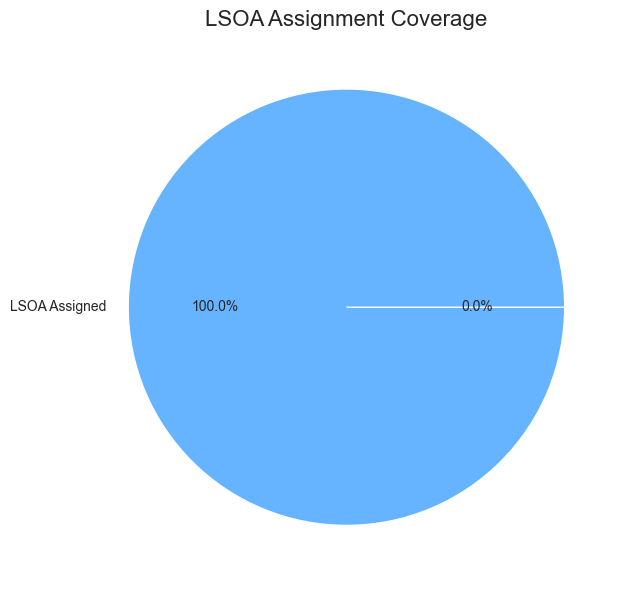

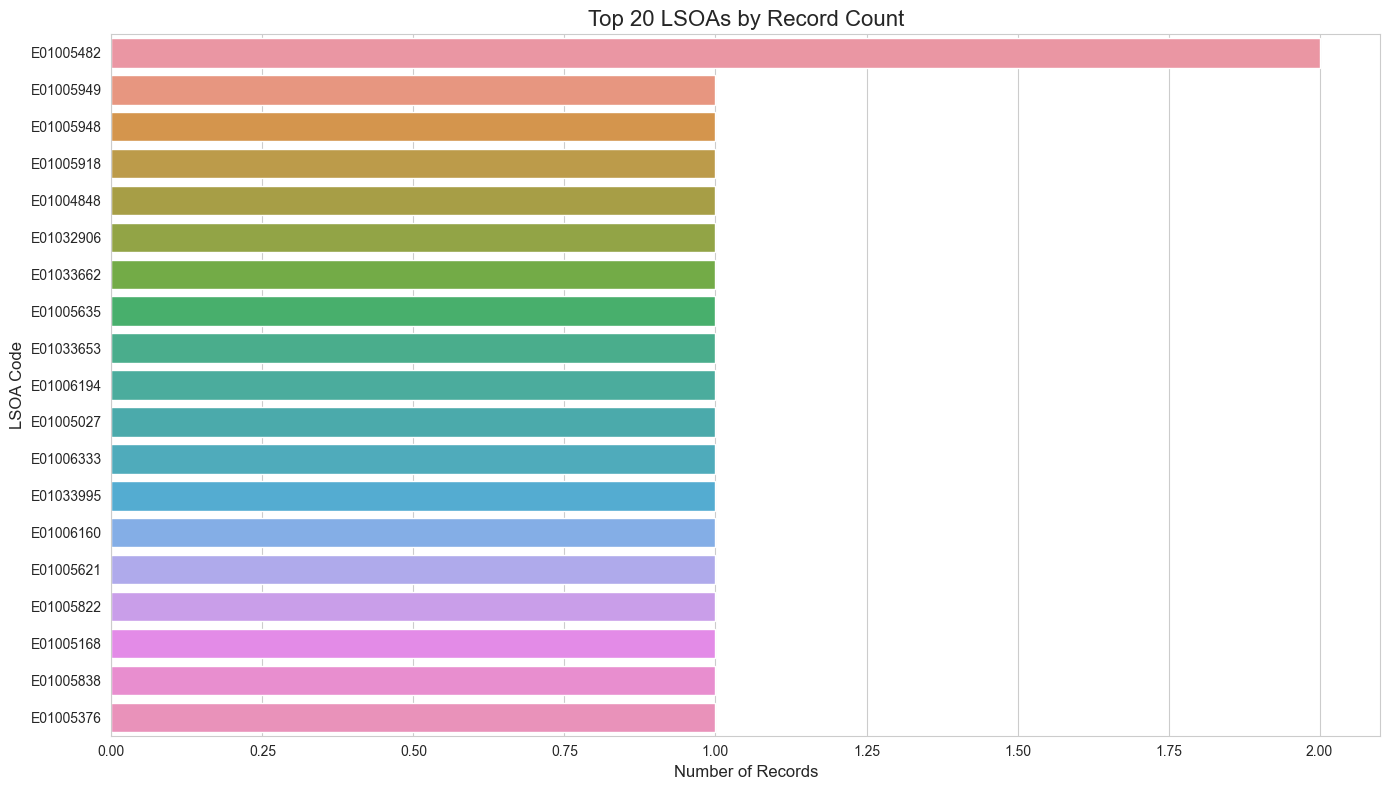

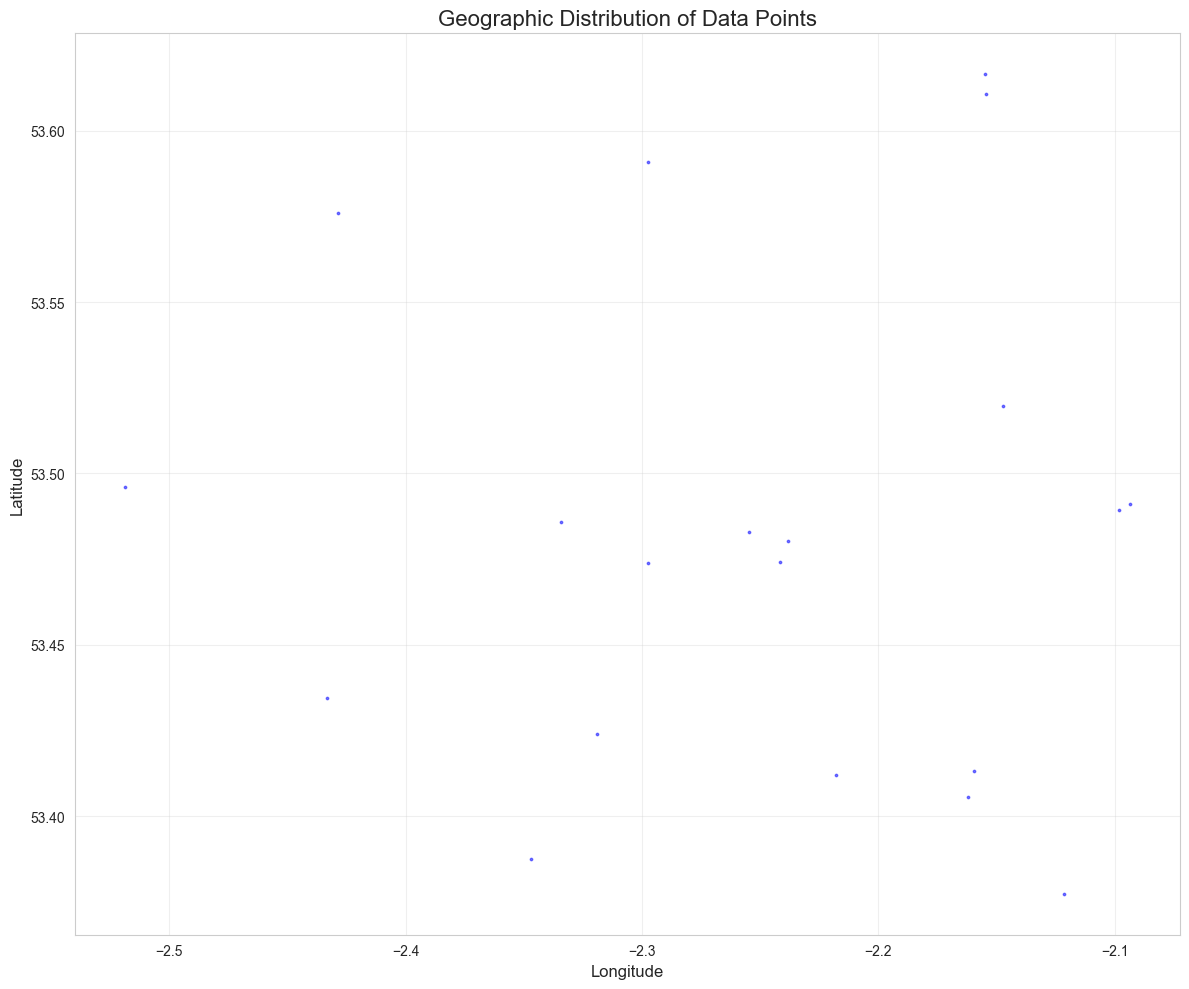

In [61]:
# Example usage:
if __name__ == "__main__":
    df, outputs = add_lsoa_codes_by_coordinates(
    file_path="data/rawdata/transport/cycle_hubs.csv",
    longitude_col="WGS84_Longitude",
    latitude_col="WGS84_Latitude",
    gm_lsoa_shapefile="data/gm_shape_wsg84/gm_shape_wsg84.shp",
    output_dir="data/preprocessed/transport",
    crs="EPSG:4326",
    lsoa_code_field="LSOA21CD"
)

In [62]:
df = pd.read_csv("data/preprocessed/transport/cycle_hubs_cleaned.csv")
df.head()

,id,hub_name,easting,northing,capacity,open_mon_fri,open_sat,open_sun,lockers,showers,membership,description,district,hotlink,open,wgs84_longitude,wgs84_latitude,lsoa_code
0,0,Bury Interchange,380410,410510,39,06:00-00:00,06:00-00:00,06:00-00:00,Y,N,TFGM,Cycle Hubs are the ideal place to leave your b...,Bury,http://cycling.tfgm.com/Pages/join-a-hub.aspx,Y,-2.297588,53.590790,E01005027
1,0,City Tower,384294,398200,194,06:00-20:00,08:00-17:00,08:00-17:00,Y,Y,TFGM,Cycle Hubs are the ideal place to leave your b...,Manchester,http://cycling.tfgm.com/Pages/join-a-hub.aspx,Y,-2.238132,53.480315,E01033653
2,0,Ashton-under-Lyne bus station,393588,399169,41,06:00-00:00,06:00-00:00,06:00-00:00,Y,N,NR,Northern Rail responsibility from 2020,Tameside,NaN,Y,-2.098090,53.489217,E01005948
3,0,Stockport town centre,389477,390704,41,06:00-00:00,06:00-00:00,06:00-00:00,Y,N,TFGM,Cycle Hubs are the ideal place to leave your b...,Stockport,http://cycling.tfgm.com/Pages/join-a-hub.aspx,Y,-2.159764,53.413059,E01005918
4,0,Bolton rail station,371939,408634,50,06:00-00:00,06:00-0000,06:00-00:00,N,N,TFGM,Cycle Hubs are the ideal place to leave your b...,Bolton,http://cycling.tfgm.com/Pages/join-a-hub.aspx,Y,-2.428535,53.575958,E01004848


In [64]:
df.columns

Index(['id', 'hub_name', 'easting', 'northing', 'capacity', 'open_mon_fri',
       'open_sat', 'open_sun', 'lockers', 'showers', 'membership',
       'description', 'district', 'hotlink', 'open', 'wgs84_longitude',
       'wgs84_latitude', 'lsoa_code'],
      dtype='object')

In [66]:
# 1. Filter rows where lsoa_code is not null
df_filtered = df[df['lsoa_code'].notnull()]

# 2. Drop unnecessary columns — specify the ones you want to remove
columns_to_drop = ['easting', 'northing', 'open_mon_fri',
       'open_sat', 'open_sun', 'lockers', 'showers', 'membership',
       'description', 'hotlink', 'open']

df_cleaned = df_filtered.drop(columns=columns_to_drop)
df_cleaned.head()

,id,hub_name,capacity,district,wgs84_longitude,wgs84_latitude,lsoa_code
0,0,Bury Interchange,39,Bury,-2.297588,53.590790,E01005027
1,0,City Tower,194,Manchester,-2.238132,53.480315,E01033653
2,0,Ashton-under-Lyne bus station,41,Tameside,-2.098090,53.489217,E01005948
3,0,Stockport town centre,41,Stockport,-2.159764,53.413059,E01005918
4,0,Bolton rail station,50,Bolton,-2.428535,53.575958,E01004848


In [70]:
# print(df_cleaned.isnull().sum())
df_cleaned.to_csv("data/preprocessed/transport/cycle_hubs_cleaned2.csv", index=False)

### traffic_signal_locations

Processing dataset: data/rawdata/transport/traffic_signal_locations.csv
Original dataset shape: (2488, 23)
Removed 0 duplicate rows. New shape: (2488, 23)
Records with missing coordinates: 0 (0.00%)
Records with invalid UK coordinates: 30 (1.21%)
Valid coordinates for geocoding: 2458 (98.79%)
Using shapefile for geocoding: data/gm_shape_wsg84/gm_shape_wsg84.shp
Loading LSOA shapefile...
Error loading shapefile: module 'fiona' has no attribute 'path'
Attempting to use PyShp as fallback...
Successfully loaded shapefile using PyShp. Found 1702 polygons.
Shapefile CRS: EPSG:4326
Shapefile columns: ['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'district', 'geometry']
Number of LSOA polygons: 1702
Using specified LSOA code field: LSOA21CD
Sample LSOA codes from shapefile: ['E01006100', 'E01005446', 'E01004800', 'E01006253', 'E01005257']
Performing spatial join to determine LSOA codes for 2458 points...
Points successfull

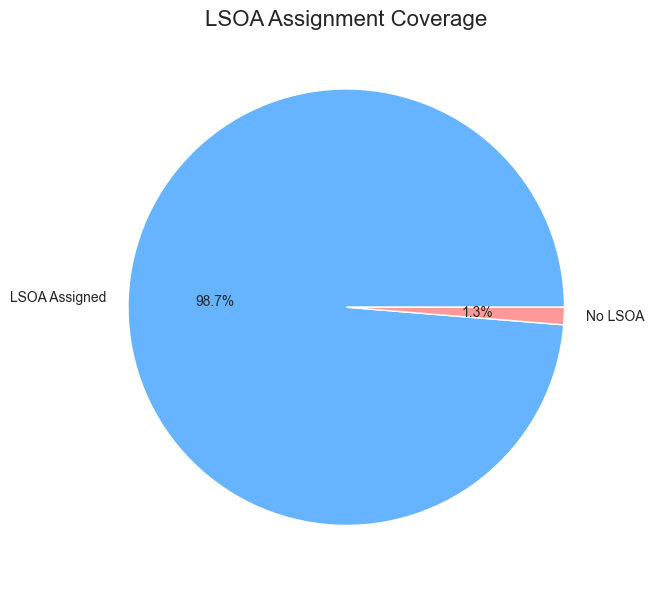

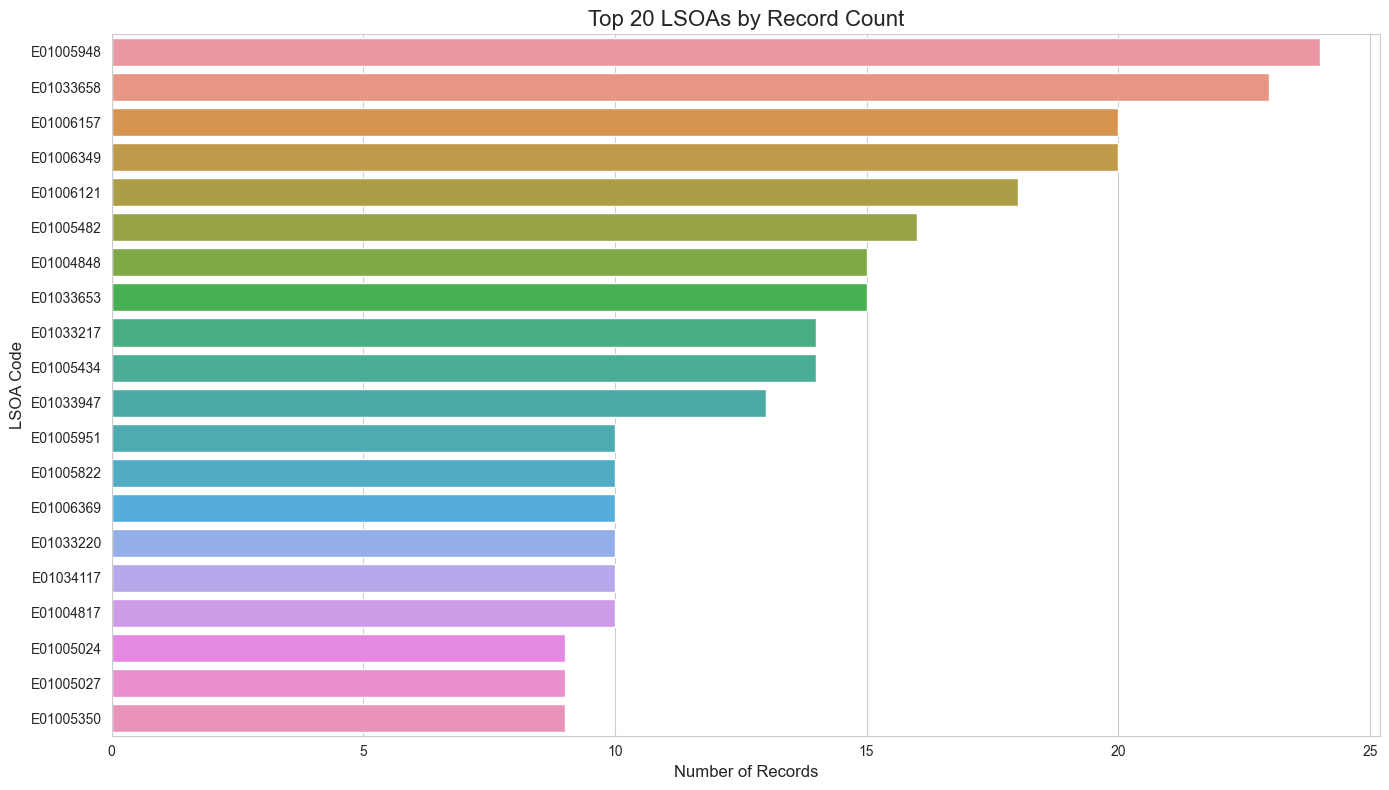

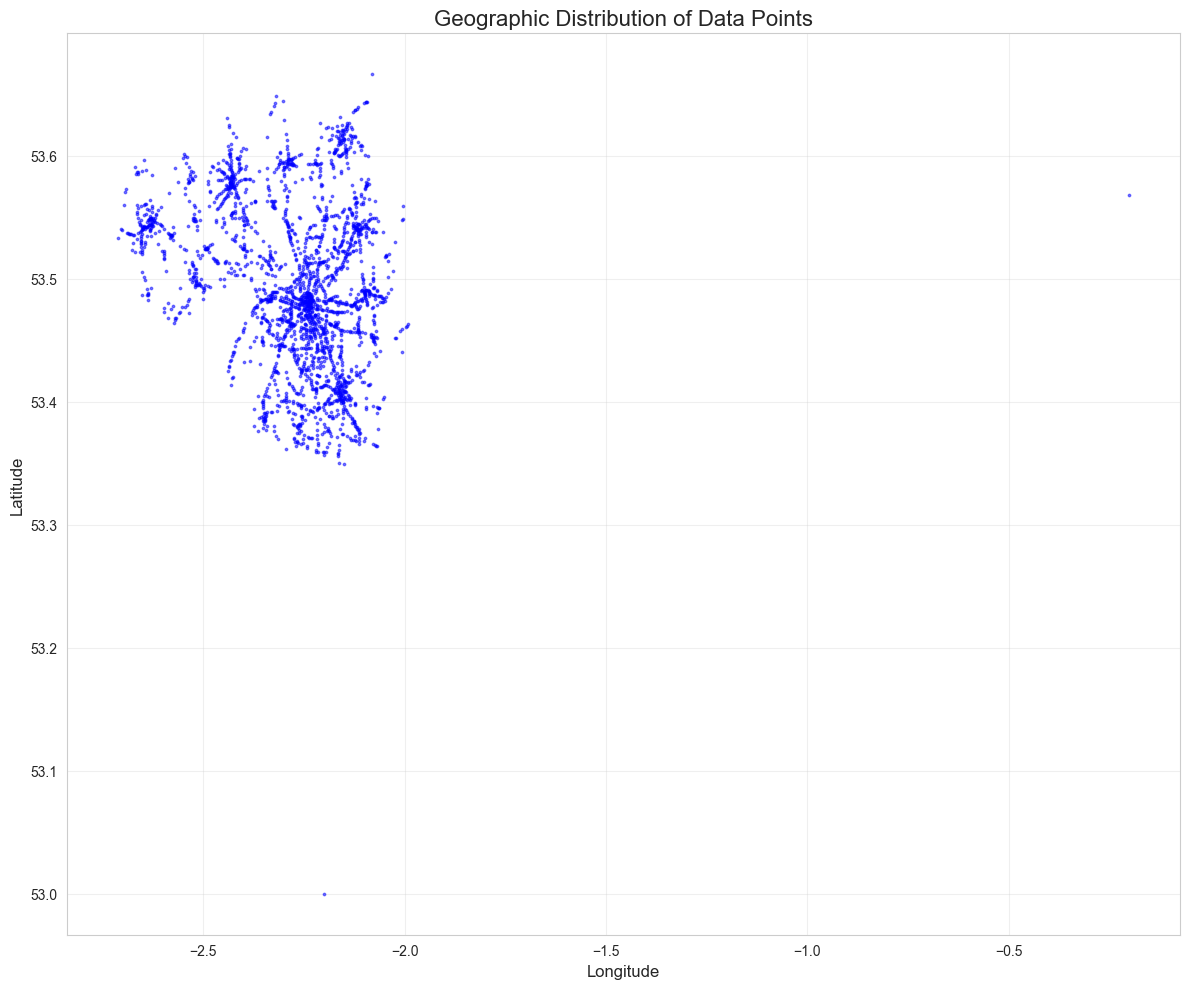

In [46]:
# Example usage:
if __name__ == "__main__":
    df, outputs = add_lsoa_codes_by_coordinates(
    file_path="data/rawdata/transport/traffic_signal_locations.csv",
    longitude_col="Longitude",
    latitude_col="Latitude",
    gm_lsoa_shapefile="data/gm_shape_wsg84/gm_shape_wsg84.shp",
    output_dir="data/preprocessed/transport",
    crs="EPSG:4326",
    lsoa_code_field="LSOA21CD"
)

In [53]:
df = pd.read_csv("data/preprocessed/transport/traffic_signal_locations_cleaned.csv")
df.head()


,fras_ref,description,type,controller,otu_omu,bus_gate,easting,northing,type_of_control,scoot_region,...,authority,hways_agency_area,ha_agency_maintained,longitude,latitude,nis_node,comments,crossing_facility,krn,lsoa_code
0,1,Albion St/Whitworth St West,Signal,ST900,Gemini UTMC,NO,383626,397526,UTC,NaN,...,Manchester,NaN,NO,-2.248157,53.474223,0,NaN,NaN,No,E01034131
1,2,Albion St/Great Bridgewater St/Lower Mosley St,Signal,ST800,Gemini UTMC,NO,383677,397629,UTC,NaN,...,Manchester,NaN,NO,-2.247394,53.475150,0,NaN,NaN,No,E01033677
2,3,Albert Sq/John Dalton St/Cross St,Signal,ST950 ELV L,Integral UTMC,NO,383826,398186,SCOOT,CG,...,Manchester,NaN,NO,-2.245177,53.480161,0,NaN,NaN,No,E01033658
3,4,Fairfield St/Travis St/Nield St,Signal,ST800,Gemini UTMC,NO,384988,397736,UTC,NaN,...,Manchester,NaN,NO,-2.227647,53.476151,0,NaN,NaN,No,E01033661
4,5,Princess Rd/Greenheys Ln,Signal,ST800,Gemini UTMC,NO,383832,396222,SCOOT,CP,...,Manchester,NaN,NO,-2.244988,53.462507,1,NaN,NaN,Yes,E01034118


In [52]:
df.columns

Index(['fras_ref', 'description', 'type', 'controller', 'otu_omu', 'bus_gate',
       'easting', 'northing', 'type_of_control', 'scoot_region',
       'scoot_status', 'scoot_commission_date', 'scoot_anticip_date',
       'scoot_progress', 'authority', 'hways_agency_area',
       'ha_agency_maintained', 'longitude', 'latitude', 'nis_node', 'comments',
       'crossing_facility', 'krn', 'lsoa_code'],
      dtype='object')

In [54]:
# 1. Filter rows where lsoa_code is not null
df_filtered = df[df['lsoa_code'].notnull()]

# 2. Drop unnecessary columns — specify the ones you want to remove
columns_to_drop = ['fras_ref', 'controller', 'otu_omu', 'bus_gate',
       'easting', 'northing', 'type_of_control', 'scoot_region',
       'scoot_status', 'scoot_commission_date', 'scoot_anticip_date',
       'scoot_progress', 'hways_agency_area',
       'ha_agency_maintained', 'nis_node', 'comments',
       'crossing_facility', 'krn']

df_cleaned = df_filtered.drop(columns=columns_to_drop)
df_cleaned.head()


,description,type,authority,longitude,latitude,lsoa_code
0,Albion St/Whitworth St West,Signal,Manchester,-2.248157,53.474223,E01034131
1,Albion St/Great Bridgewater St/Lower Mosley St,Signal,Manchester,-2.247394,53.475150,E01033677
2,Albert Sq/John Dalton St/Cross St,Signal,Manchester,-2.245177,53.480161,E01033658
3,Fairfield St/Travis St/Nield St,Signal,Manchester,-2.227647,53.476151,E01033661
4,Princess Rd/Greenheys Ln,Signal,Manchester,-2.244988,53.462507,E01034118


In [55]:
df_cleaned.to_csv('data/preprocessed/transport/traffic_signal_locations_cleaned.csv', index=False)

### Metrolink stops and rail stops

Processing dataset: data/rawdata/transport/metrolink_stops_and_rail_stations.csv
Original dataset shape: (190, 12)
Removed 0 duplicate rows. New shape: (190, 12)
Records with missing coordinates: 0 (0.00%)
Records with invalid UK coordinates: 0 (0.00%)
Valid coordinates for geocoding: 190 (100.00%)
Using shapefile for geocoding: data/gm_shape_wsg84/gm_shape_wsg84.shp
Loading LSOA shapefile...
Error loading shapefile: module 'fiona' has no attribute 'path'
Attempting to use PyShp as fallback...
Successfully loaded shapefile using PyShp. Found 1702 polygons.
Shapefile CRS: EPSG:4326
Shapefile columns: ['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'district', 'geometry']
Number of LSOA polygons: 1702
Using specified LSOA code field: LSOA21CD
Sample LSOA codes from shapefile: ['E01005316', 'E01033978', 'E01005338', 'E01005178', 'E01006019']
Performing spatial join to determine LSOA codes for 190 points...
Points succes

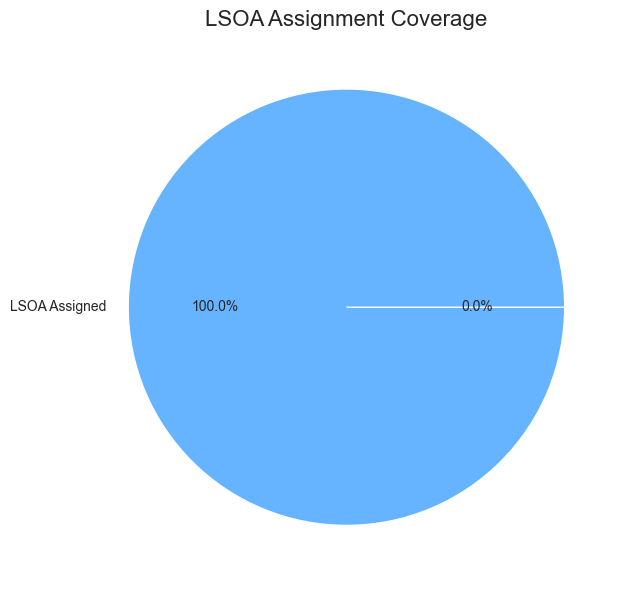

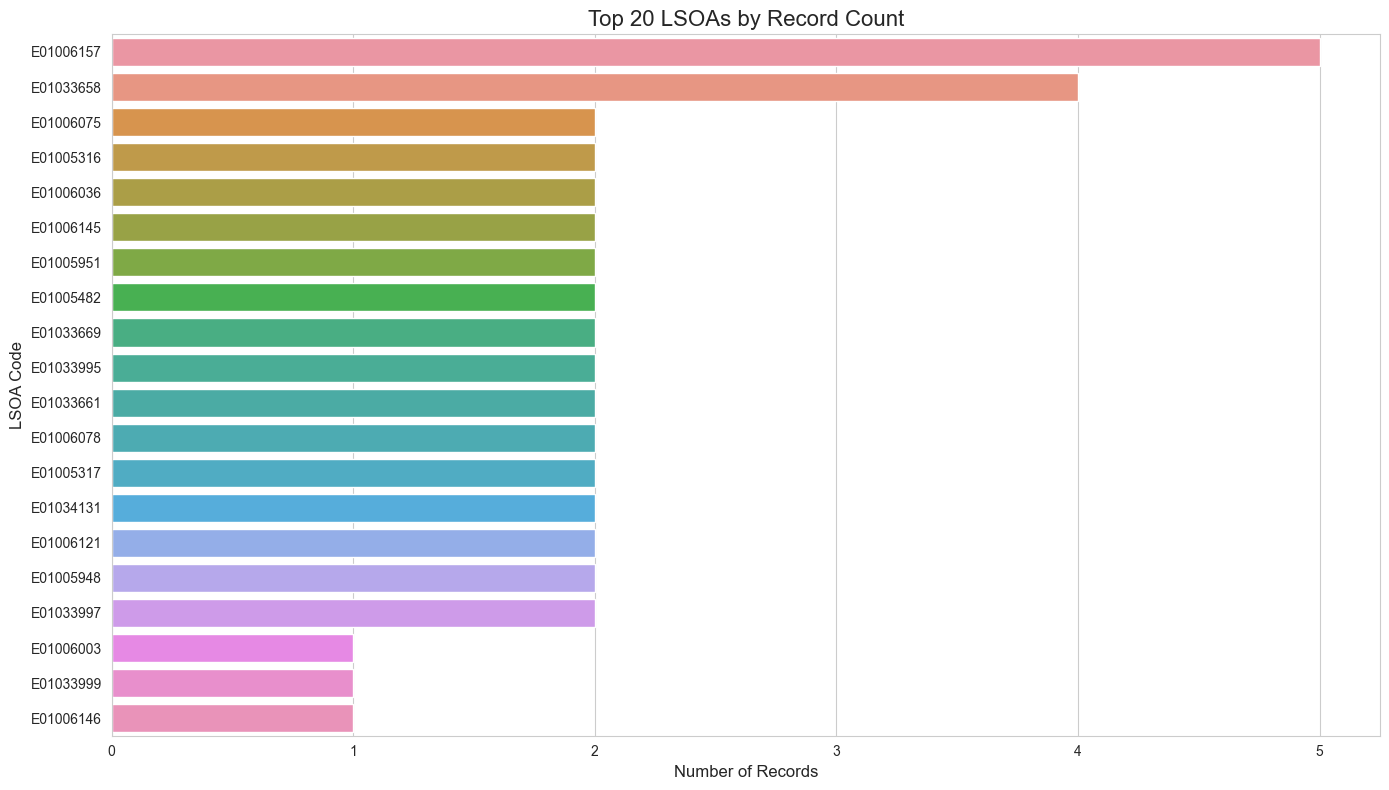

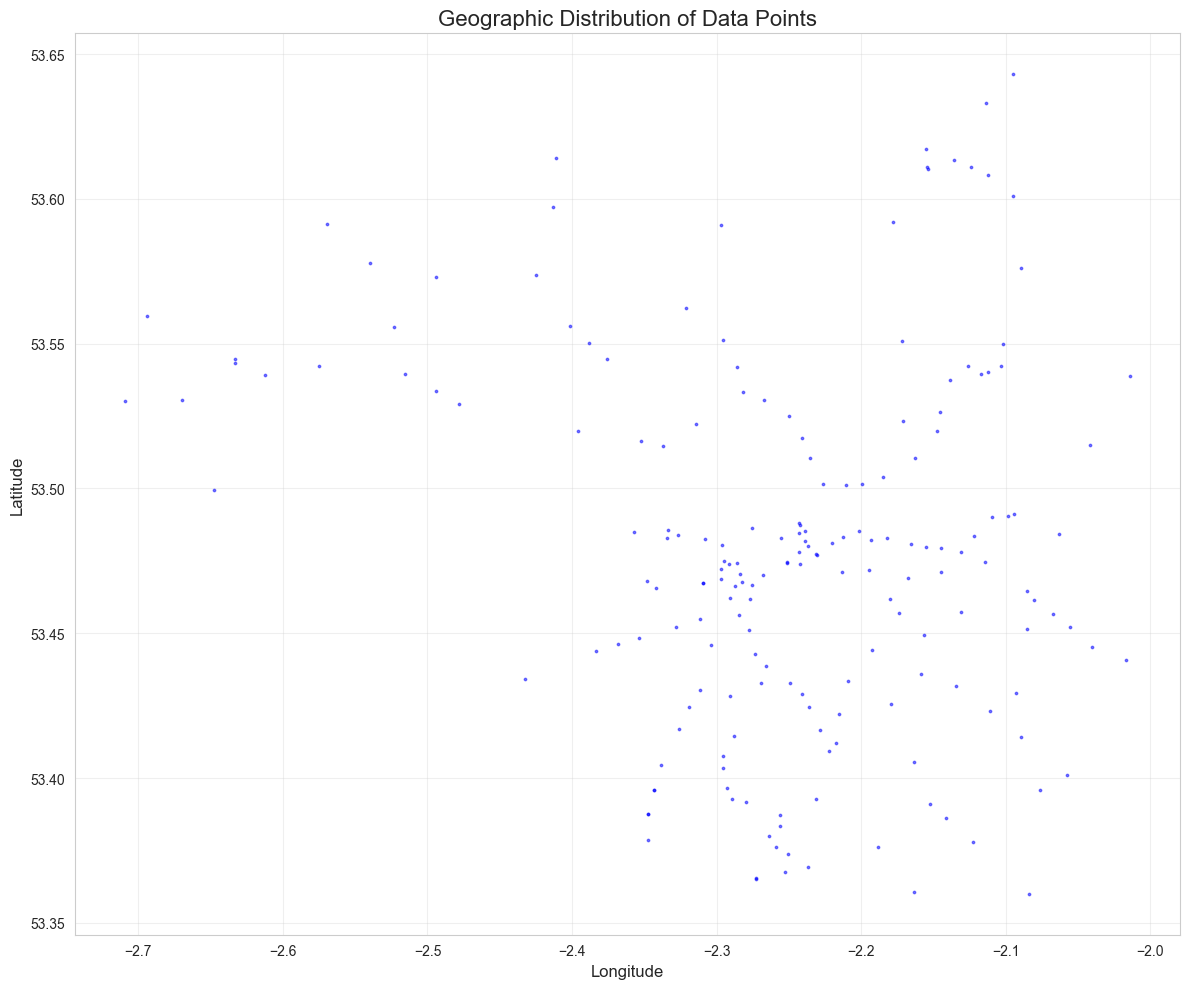

In [79]:
# Example usage:
if __name__ == "__main__":
    df, outputs = add_lsoa_codes_by_coordinates(
    file_path="data/rawdata/transport/metrolink_stops_and_rail_stations.csv",
    longitude_col="GPSLAT",
    latitude_col="GPSLON",
    gm_lsoa_shapefile="data/gm_shape_wsg84/gm_shape_wsg84.shp",
    output_dir="data/preprocessed/transport",
    crs="EPSG:4326",
    lsoa_code_field="LSOA21CD"
)

In [85]:
df = pd.read_csv("data/preprocessed/transport/metrolink_stops_and_rail_stations_cleaned.csv")
df.head()

,nptref,smsref,gpslat,gpslon,gmgrfe,gmgrfn,rstnam,mainrd,sidest,nettyp,gazref,netwrf,lsoa_code
0,9100ALTRNHM,NaN,53.387668,-2.347158,377008,387924,ALTRINCHAM INTERCHANGE,STAMFORD NEW RD,MOSS LANE,R,E0028261,SJR032,E01006075
1,9100ARDWICK,NaN,53.471206,-2.213369,385934,397183,ARDWICK,DEVONSHIRE ST N,BLIND LANE,R,E0028484,EBR116,E01005061
2,9100ASHBRYS,NaN,53.471867,-2.194752,387150,397253,ASHBURYS,POTTERY LANE,JARMAIN STREET,R,N0074883,EBR115,E01005106
3,9100ASHONUL,NaN,53.491279,-2.094327,393839,399399,ASHTON UNDER LYNE,SACKVILLE ST,TURNER LANE,R,E0028492,EHR101,E01005948
4,9100ATHERTN,NaN,53.529109,-2.477990,368412,403710,ATHERTON,UPTON ROAD,BOLTON ROAD,R,E0028727,WKR069,E01006290


In [86]:
df.columns

Index(['nptref', 'smsref', 'gpslat', 'gpslon', 'gmgrfe', 'gmgrfn', 'rstnam',
       'mainrd', 'sidest', 'nettyp', 'gazref', 'netwrf', 'lsoa_code'],
      dtype='object')

In [88]:
# 1. Filter rows where lsoa_code is not null
df_filtered = df[df['lsoa_code'].notnull()]

# 2. Drop unnecessary columns — specify the ones you want to remove
columns_to_drop = ['smsref', 'gmgrfe', 'gmgrfn', 'gazref', 'netwrf']

df_cleaned = df_filtered.drop(columns=columns_to_drop)
df_cleaned.head()

,nptref,gpslat,gpslon,rstnam,mainrd,sidest,nettyp,lsoa_code
0,9100ALTRNHM,53.387668,-2.347158,ALTRINCHAM INTERCHANGE,STAMFORD NEW RD,MOSS LANE,R,E01006075
1,9100ARDWICK,53.471206,-2.213369,ARDWICK,DEVONSHIRE ST N,BLIND LANE,R,E01005061
2,9100ASHBRYS,53.471867,-2.194752,ASHBURYS,POTTERY LANE,JARMAIN STREET,R,E01005106
3,9100ASHONUL,53.491279,-2.094327,ASHTON UNDER LYNE,SACKVILLE ST,TURNER LANE,R,E01005948
4,9100ATHERTN,53.529109,-2.477990,ATHERTON,UPTON ROAD,BOLTON ROAD,R,E01006290


In [89]:
df_cleaned.columns = ['stop_id', 'latitude', 'longitude', 'station_name', 'main_road', 'side_street', 'network_type', 'lspa_code']
df_cleaned.head()

,stop_id,latitude,longitude,station_name,main_road,side_street,network_type,lspa_code
0,9100ALTRNHM,53.387668,-2.347158,ALTRINCHAM INTERCHANGE,STAMFORD NEW RD,MOSS LANE,R,E01006075
1,9100ARDWICK,53.471206,-2.213369,ARDWICK,DEVONSHIRE ST N,BLIND LANE,R,E01005061
2,9100ASHBRYS,53.471867,-2.194752,ASHBURYS,POTTERY LANE,JARMAIN STREET,R,E01005106
3,9100ASHONUL,53.491279,-2.094327,ASHTON UNDER LYNE,SACKVILLE ST,TURNER LANE,R,E01005948
4,9100ATHERTN,53.529109,-2.477990,ATHERTON,UPTON ROAD,BOLTON ROAD,R,E01006290


In [91]:
df_cleaned.to_csv('data/preprocessed/transport/metrolink_stops_and_rail_stations_cleaned2.csv', index=False)

### fire_and_rescue

Processing dataset: data/rawdata/emergency_service/fire_and_rescue.csv
Original dataset shape: (47, 10)
Removed 0 duplicate rows. New shape: (47, 10)
Records with missing coordinates: 0 (0.00%)
Records with invalid UK coordinates: 1 (2.13%)
Valid coordinates for geocoding: 46 (97.87%)
Using shapefile for geocoding: data/gm_shape_wsg84/gm_shape_wsg84.shp
Loading LSOA shapefile...
Error loading shapefile: module 'fiona' has no attribute 'path'
Attempting to use PyShp as fallback...
Successfully loaded shapefile using PyShp. Found 1702 polygons.
Shapefile CRS: EPSG:4326
Shapefile columns: ['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'district', 'geometry']
Number of LSOA polygons: 1702
Using specified LSOA code field: LSOA21CD
Sample LSOA codes from shapefile: ['E01006079', 'E01006017', 'E01033979', 'E01005454', 'E01005288']
Performing spatial join to determine LSOA codes for 46 points...
Points successfully assigned

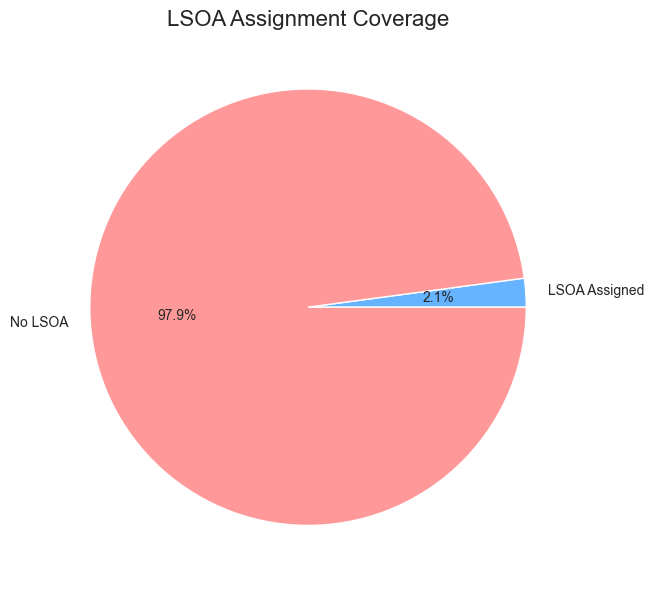

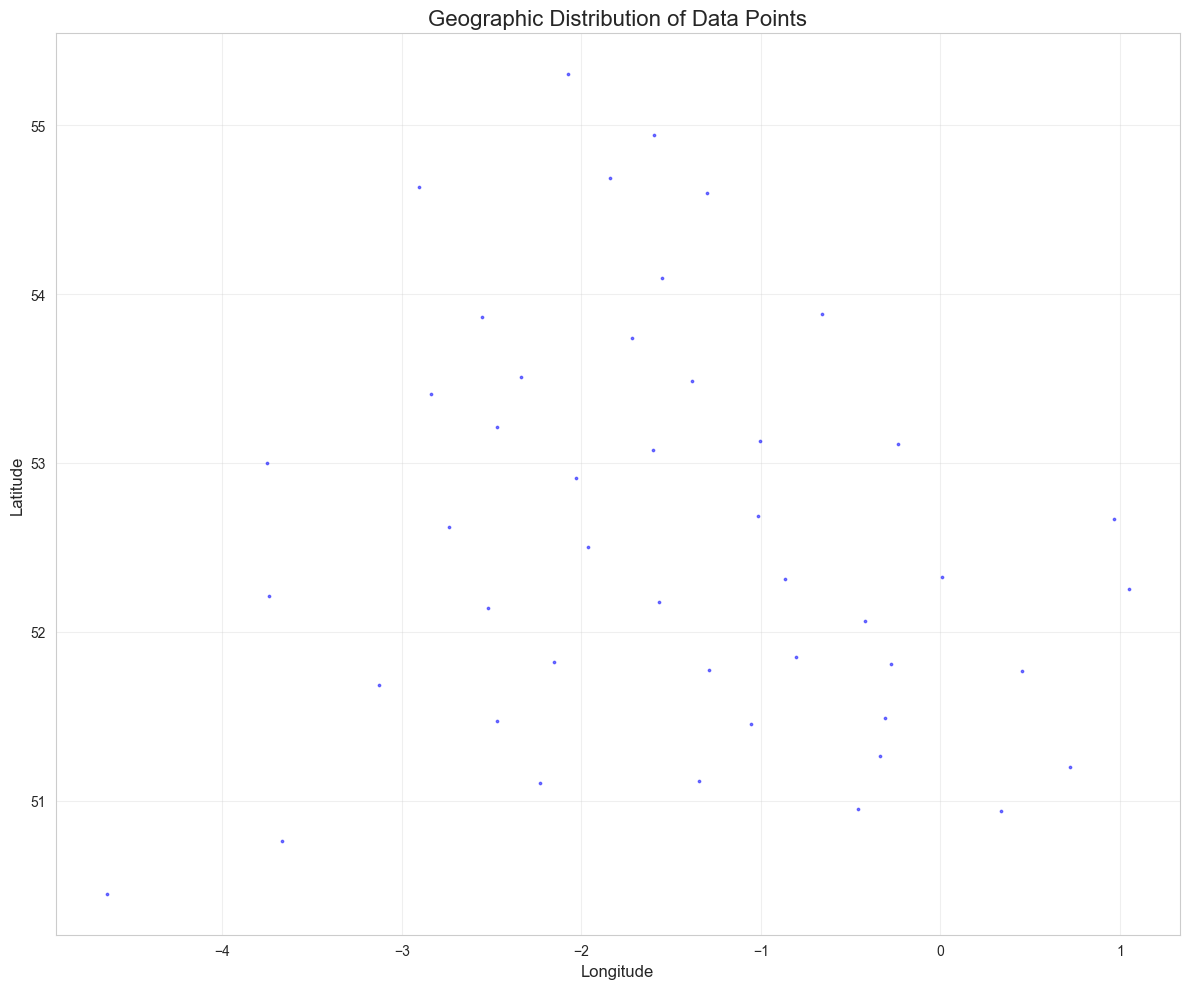

In [92]:
# Example usage:
if __name__ == "__main__":
    df, outputs = add_lsoa_codes_by_coordinates(
    file_path="data/rawdata/emergency_service/fire_and_rescue.csv",
    longitude_col="LONG",
    latitude_col="LAT",
    gm_lsoa_shapefile="data/gm_shape_wsg84/gm_shape_wsg84.shp",
    output_dir="data/preprocessed/emergency_service",
    crs="EPSG:4326",
    lsoa_code_field="LSOA21CD"
)

In [93]:
df = pd.read_csv("data/preprocessed/emergency_service/fire_and_rescue_cleaned.csv")
df.head()

,objectid,fra21cd,fra21nm,bng_e,bng_n,long,lat,shape__area,shape__length,globalid,lsoa_code
0,1,E31000001,Avon,367434,175259,-2.470290,51.47534,1.353245e+09,204522.330444,4abf0549-2628-4051-911d-65809520c522,NaN
1,2,E31000002,Bedfordshire,508276,242055,-0.421840,52.06630,1.227957e+09,213752.126277,d689cb69-5b9e-4572-a381-bbbd19cd8476,NaN
2,3,E31000003,Royal Berkshire,465737,173159,-1.055300,51.45360,1.259972e+09,255746.320378,04528383-7c3e-4953-9df8-862c99c34e18,NaN
3,4,E31000004,Buckinghamshire & Milton Keynes,482506,217841,-0.803480,51.85308,1.881766e+09,347079.767370,00a25e6f-403e-4f6e-ad46-8237166f9c50,NaN
4,5,E31000005,Cambridgeshire,536856,271834,0.006854,52.32755,3.397580e+09,369774.715909,4fa8477f-2e52-473f-baa2-ff597bd84061,NaN


In [94]:
df.columns

Index(['objectid', 'fra21cd', 'fra21nm', 'bng_e', 'bng_n', 'long', 'lat',
       'shape__area', 'shape__length', 'globalid', 'lsoa_code'],
      dtype='object')

In [96]:
# 1. Filter rows where lsoa_code is not null
df_filtered = df[df['lsoa_code'].notnull()]
#df_filtered.head()
# 2. Drop unnecessary columns — specify the ones you want to remove
columns_to_drop = ['objectid', 'bng_e', 'bng_n']

df_cleaned = df_filtered.drop(columns=columns_to_drop)
df_cleaned.head()

,fra21cd,fra21nm,long,lat,shape__area,shape__length,globalid,lsoa_code
35,E31000040,Greater Manchester,-2.33407,53.50615,1.273598e+09,206057.361346,cb473d2d-542e-4caf-939a-af1c65a85b42,E01005698


In [97]:
df_cleaned.columns = ['fra_2021_code', 'fra_2021_name', 'longitude', 'latitude', 'shape_area', 'shape_length', 'global_id', 'lsoa_code']
df_cleaned.head()

,fra_2021_code,fra_2021_name,longitude,latitude,shape_area,shape_length,global_id,lsoa_code
35,E31000040,Greater Manchester,-2.33407,53.50615,1.273598e+09,206057.361346,cb473d2d-542e-4caf-939a-af1c65a85b42,E01005698


In [98]:
df_cleaned.to_csv('data/preprocessed/emergency_service/fire_and_rescue_cleaned2.csv', index=False)

### police_force_areas

Processing dataset: data/rawdata/emergency_service/police_force_areas.csv
Original dataset shape: (43, 10)
Removed 0 duplicate rows. New shape: (43, 10)
Records with missing coordinates: 0 (0.00%)
Records with invalid UK coordinates: 0 (0.00%)
Valid coordinates for geocoding: 43 (100.00%)
Using shapefile for geocoding: data/gm_shape_wsg84/gm_shape_wsg84.shp
Loading LSOA shapefile...
Error loading shapefile: module 'fiona' has no attribute 'path'
Attempting to use PyShp as fallback...
Successfully loaded shapefile using PyShp. Found 1702 polygons.
Shapefile CRS: EPSG:4326
Shapefile columns: ['FID', 'LSOA21CD', 'LSOA21NM', 'LSOA21NMW', 'BNG_E', 'BNG_N', 'LAT', 'LONG', 'Shape__Are', 'Shape__Len', 'GlobalID', 'district', 'geometry']
Number of LSOA polygons: 1702
Using specified LSOA code field: LSOA21CD
Sample LSOA codes from shapefile: ['E01005185', 'E01005574', 'E01006395', 'E01005581', 'E01005439']
Performing spatial join to determine LSOA codes for 43 points...
Points successfully assi

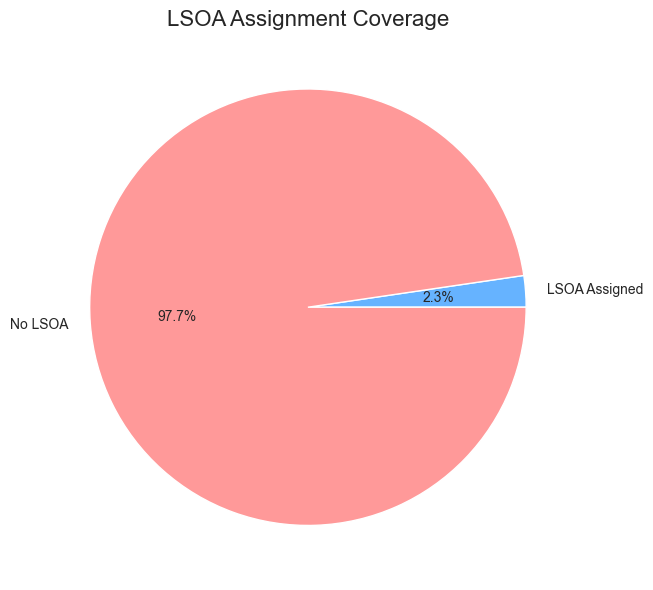

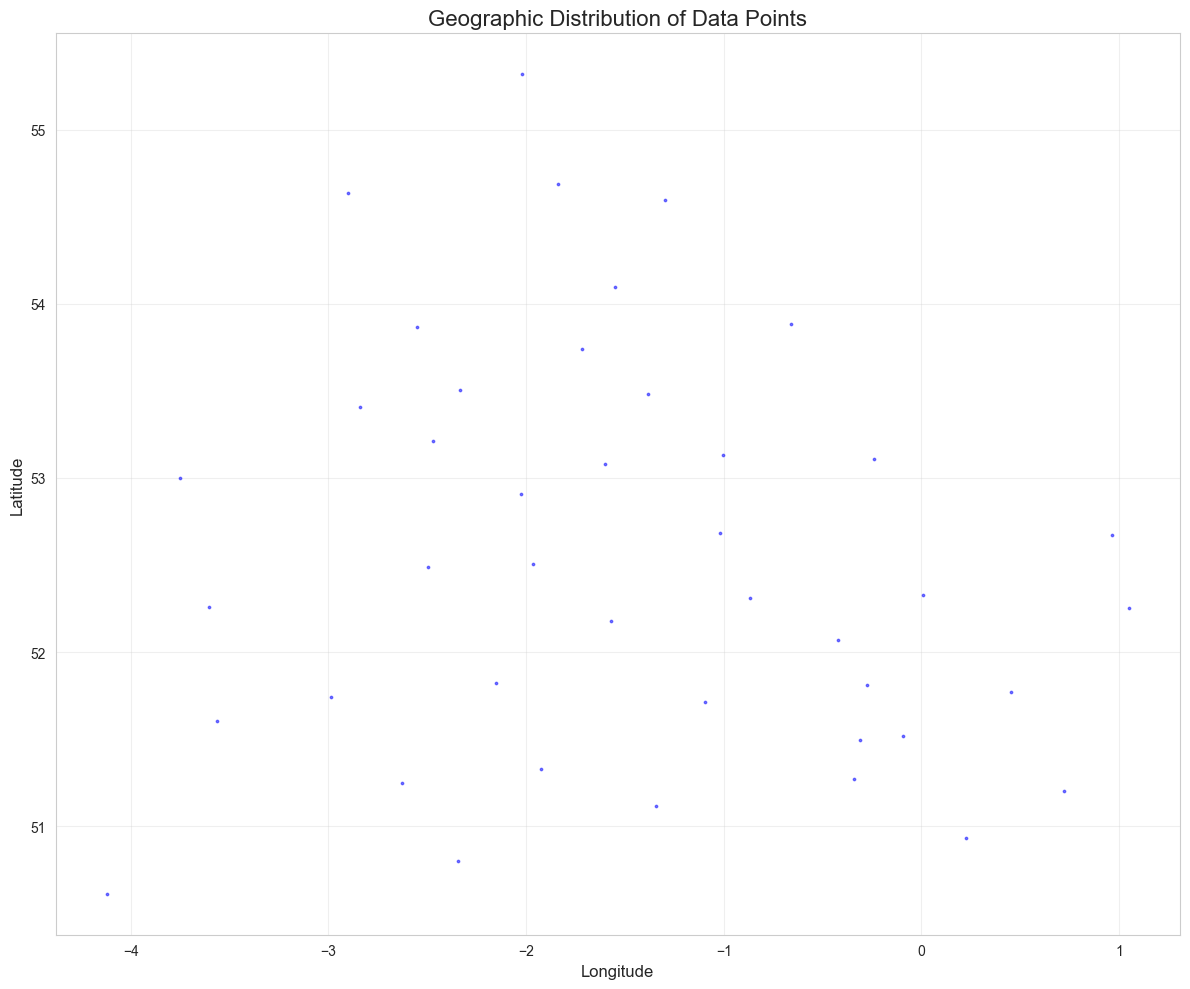

In [99]:
# Example usage:
if __name__ == "__main__":
    df, outputs = add_lsoa_codes_by_coordinates(
    file_path="data/rawdata/emergency_service/police_force_areas.csv",
    longitude_col="LONG",
    latitude_col="LAT",
    gm_lsoa_shapefile="data/gm_shape_wsg84/gm_shape_wsg84.shp",
    output_dir="data/preprocessed/emergency_service",
    crs="EPSG:4326",
    lsoa_code_field="LSOA21CD"
)

In [100]:
df = pd.read_csv("data/preprocessed/emergency_service/police_force_areas_cleaned.csv")
df.head()

,fid,pfa23cd,pfa23nm,bng_e,bng_n,long,lat,shape__area,shape__length,globalid,lsoa_code
0,1,E23000001,Metropolitan Police,517517,178394,-0.30863,51.49228,1.580796e+09,278932.455647,e87264a8-d2d8-46f0-b4e9-e4e4a602ed4c,NaN
1,2,E23000002,Cumbria,341868,527180,-2.90213,54.63638,6.830387e+09,553228.905433,922a4bb7-906f-4e41-a95b-f46f5266594e,NaN
2,3,E23000003,Lancashire,363725,441045,-2.55307,53.86435,3.069334e+09,429628.127469,de051ac2-57eb-4fe4-b07c-e0e0da3e910a,NaN
3,4,E23000004,Merseyside,344345,390165,-2.83861,53.40536,6.448469e+08,248017.357000,bfda3a70-af16-43ad-8f39-d97fea639074,NaN
4,5,E23000005,Greater Manchester,377929,401095,-2.33423,53.50609,1.273634e+09,206125.590905,63eabc12-a25c-4cc7-9115-306eb0802c92,E01005698


In [101]:
df.columns

Index(['fid', 'pfa23cd', 'pfa23nm', 'bng_e', 'bng_n', 'long', 'lat',
       'shape__area', 'shape__length', 'globalid', 'lsoa_code'],
      dtype='object')

In [102]:
# 1. Filter rows where lsoa_code is not null
df_filtered = df[df['lsoa_code'].notnull()]
#df_filtered.head()
# 2. Drop unnecessary columns — specify the ones you want to remove
columns_to_drop = ['fid', 'bng_e', 'bng_n']

df_cleaned = df_filtered.drop(columns=columns_to_drop)
df_cleaned.head()

,pfa23cd,pfa23nm,long,lat,shape__area,shape__length,globalid,lsoa_code
4,E23000005,Greater Manchester,-2.33423,53.50609,1.273634e+09,206125.590905,63eabc12-a25c-4cc7-9115-306eb0802c92,E01005698


In [103]:
df_cleaned.columns = ['pfa_2023_code', 'pfa_2023_name', 'longitude', 'latitude', 'shape_area', 'shape_length', 'global_id', 'lsoa_code']
df_cleaned.head()

,pfa_2023_code,pfa_2023_name,longitude,latitude,shape_area,shape_length,global_id,lsoa_code
4,E23000005,Greater Manchester,-2.33423,53.50609,1.273634e+09,206125.590905,63eabc12-a25c-4cc7-9115-306eb0802c92,E01005698


In [104]:
df_cleaned.to_csv('data/preprocessed/emergency_service/police_force_areas_cleaned2.csv', index=False)